# Libraries

In [37]:
import importlib
import config
import os
importlib.reload(config)

from langchain_tavily import TavilySearch

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model

import json
from langchain_core.messages import ToolMessage

# Tools

In [35]:
os.environ['TAVILY_API_KEY'] = config.Config.TAVILY_API_KEY
tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.langchain.dev/langgraph/',
   'title': 'LangGraph - LangChain Blog',
   'content': "TL;DR: LangGraph is module built on top of LangChain to better enable creation of cyclical graphs, often needed for agent runtimes. This state is updated by nodes in the graph, which return operations to attributes of this state (in the form of a key-value store). After adding nodes, you can then add edges to create the graph. An example of this may be in the basic agent runtime, where we always want the model to be called after we call a tool. The state of this graph by default contains concepts that should be familiar to you if you've used LangChain agents: `input`, `chat_history`, `intermediate_steps` (and `agent_outcome` to represent the most recent agent outcome)",
   'score': 0.7407191,
   'raw_content': None},
  {'url': 'https://medium.com/@cplog/introduction

# State Class

In [38]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

# Graph

In [39]:
llm = init_chat_model(
    "azure_openai:gpt-4.1-nano",
    azure_deployment=config.Config.AZURE_OPENAI_DEPLOYMENT_NAME
)

graph_builder = StateGraph(State)
llm_with_tools = llm.bind_tools(tools)
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

tool_node = BasicToolNode(tools=[tool])

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

In [31]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

# Visualise graph

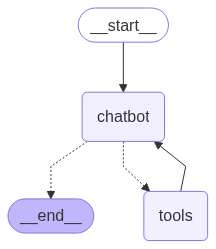

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Main

In [41]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "current weather in Singapore", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Weather in Singapore", "url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Singapore', 'region': '', 'country': 'Singapore', 'lat': 1.293, 'lon': 103.856, 'tz_id': 'Asia/Singapore', 'localtime_epoch': 1752306516, 'localtime': '2025-07-12 15:48'}, 'current': {'last_updated_epoch': 1752306300, 'last_updated': '2025-07-12 15:45', 'temp_c': 28.0, 'temp_f': 82.4, 'is_day': 1, 'condition': {'text': 'Patchy light drizzle', 'icon': '//cdn.weatherapi.com/weather/64x64/day/263.png', 'code': 1150}, 'wind_mph': 2.7, 'wind_kph': 4.3, 'wind_degree': 256, 'wind_dir': 'WSW', 'pressure_mb': 1007.0, 'pressure_in': 29.74, 'precip_mm': 0.33, 'precip_in': 0.01, 'humidity': 79, 'cloud': 25, 'feelslike_c': 32.6, 'feelslike_f': 90.7, 'windchill_c': 24.7, 'windchill_f': 76.4, 'heatindex_c': 26.8, 'heatindex_f': 80.2, 'dewpoint_c': 21.4, 'dewpoin